In [11]:
import numpy as np
from shapely.geometry import Point, LineString, Polygon
from shapely.ops import split, unary_union
from itertools import product
from collections import OrderedDict

In [62]:
def gate_coords(grid_spacing, L=41, gap=4, channel_width=11, angle=np.pi / 4):
    """Find the gate coordinates that defines the trijunction

    L: Channel length
    gap: Gap between the gates
    angle: Angle the channel makes with the x-axis [in radians]

    Returns: Gates vertices and their order
    """

    A = lambda x: np.array([[-np.cos(x), np.sin(x)], [np.sin(x), np.cos(x)]])

    point = np.array([0, 1])

    rotated_c = (point @ A(angle)) @ (np.eye(2) * L)

    tail = np.round(rotated_c.reshape((2, 1)) * np.array([[-1, 0]]).T, 2)
    head = np.round(rotated_c.reshape((2, 1)) * np.array([[0, 1]]).T, 2)

    left, right, top = (
        LineString([Point(*tail), Point(*head)]),
        LineString([Point(*(tail * -1)), Point(*head)]),
        LineString([Point(*head), Point([0, L + head[1]])]),
    )

    def shift(x, adjustment):
        x = np.array(x.coords)
        x[:, 0] += adjustment
        return x
    
    distance_to_axis = (channel_width/2 + gap/2)
    
    lcoords = shift(left, -distance_to_axis)
    rcoords = shift(right, distance_to_axis)
    tcoords = shift(top, -channel_width/2)
    tcoords_p = shift(top, channel_width/2)

    lr = np.vstack((right.coords, left.coords[::-1]))
    lr[:, 1] -= channel_width/2
    lr[0, 0] -= distance_to_axis
    lr[-1, 0] += distance_to_axis
    truncate = lr[lr[:, 1] < 0.0].copy()
    truncate = truncate @ np.array([[1, 0], [0, 0]])
    lr[lr[:, 1] < 0.0] = truncate

    coords = np.vstack(
        (lcoords, tcoords, tcoords_p[::-1], rcoords[::-1], lr, lcoords[0])
    )
    trijunction = Polygon(coords)

    xmin, xmax, ymin, ymax = (
        coords[:, 0].min(),
        coords[:, 0].max(),
        coords[:, 1].min(),
        coords[:, 1].max(),
    )

    rectangle = np.array([[xmin, ymin], [xmin, ymax], [xmax, ymax], [xmax, ymin]])

    gates = Polygon(rectangle).difference(trijunction)
    

    gates = np.array(gates.geoms)
    area = [gate.area for gate in gates]
    gates = gates[np.argsort(area)]

    coords = np.array(gates[1].exterior.coords)
    y = np.unique(coords[:, 1])
    assert len(y) == 3
    bottom_top_threshold = y[1]

    splitter = LineString(
        [
            Point(point)
            for point in product(np.unique(coords[:, 0]), [bottom_top_threshold])
        ]
    )

    top, bottom = list(gates[1].difference(splitter.buffer(gap/2)).geoms)

    left_1 = np.round(bottom.exterior.coords)
    top_1 = np.round(top.exterior.coords)
    top_2 = top_1.copy() @ [[-1, 0], [0, 1]]
    right_2 = left_1.copy() @ [[-1, 0], [0, 1]]

    coords = np.array(gates[0].exterior.coords)

    splitter = LineString(
        [Point(point) for point in product([0.0], np.unique(coords[:, 1]))]
    )

    left_2, _ = list(gates[0].difference(splitter.buffer(gap/2)).geoms)
    
    left_2 = np.round(left_2.exterior.coords)
    right_1 = left_2.copy() @ [[-1, 0], [0, 1]]
    
    gates_vertex = [
        left_1, left_2, 
        right_1, right_2, 
        top_1, top_2
    ]

    
    gate_names = ["left_1", "left_2", "right_1", "right_2", "top_1", "top_2"]
    assert min(left_1[:, 0]) == min(top_1[:, 0])
    assert max(right_2[:, 0]) == max(top_2[:, 0])
    
    boundaries = OrderedDict(xmin = min(left_1[:, 0]), xmax = max(right_2[:, 0]),
                             ymin = min(left_1[:, 1]), ymax = max(top_1[:, 1]))
            
    channel_center = OrderedDict(left = np.hstack(tail), 
                          right = np.hstack(tail*-1), 
                          top = np.hstack([0, L+head[1]]))
    print(L, head)
    
    return gates_vertex, gate_names, boundaries, channel_center 

In [63]:
L = 41
gap = 4
channel_width = 7
angle = np.pi/4

In [64]:
gates_vertices, gates_name, boundary, centers = gate_coords(0.5, L, gap, channel_width, angle)

41 [[ 0.  ]
 [28.99]]


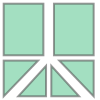

In [65]:
unary_union([Polygon(gate) for gate in gates_vertices])

In [66]:
gates_vertices

[array([[-34.,   0.],
        [-34.,  27.],
        [ -8.,  27.],
        [-34.,   0.]]),
 array([[ -2.,  23.],
        [ -2.,   0.],
        [-23.,   0.],
        [ -2.,  23.]]),
 array([[ 2., 23.],
        [ 2.,  0.],
        [23.,  0.],
        [ 2., 23.]]),
 array([[34.,  0.],
        [34., 27.],
        [ 8., 27.],
        [34.,  0.]]),
 array([[ -4.,  70.],
        [ -4.,  31.],
        [-34.,  31.],
        [-34.,  70.],
        [ -4.,  70.]]),
 array([[ 4., 70.],
        [ 4., 31.],
        [34., 31.],
        [34., 70.],
        [ 4., 70.]])]

In [67]:
boundary

OrderedDict([('xmin', -34.0), ('xmax', 34.0), ('ymin', 0.0), ('ymax', 70.0)])